In [6]:
import pandas as pd
from regimeaware.constants import DataConstants, SimulationParameters
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import entropy
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})

phi_list = [10, 25, 50]

In [7]:
mdl_wts = pd.read_pickle(f"{DataConstants.WDIR.value}/results/model.pkl")
bsl_wts = pd.read_pickle(f"{DataConstants.WDIR.value}/results/baseline.pkl")
sec_rt = pd.read_pickle(f"{DataConstants.WDIR.value}/data/sim/sec_rt.pkl")

In [8]:
# RWLS simulated returns
collect_rt_mdl = {}
for i in mdl_wts.index.get_level_values('iteration').unique():
    for phi in SimulationParameters.RISK_AVERSION.value:
        wt = mdl_wts.xs(i, level='iteration').xs(phi, level='phi')
        rt = wt.shift(1).mul(sec_rt[i]).dropna(how='all').sum(axis=1)
        collect_rt_mdl[(phi, i)] = rt
rt_mdl = pd.DataFrame.from_dict(collect_rt_mdl, orient='index').sort_index()
rt_mdl.index.names = ['phi', 'iteration']

# Baseline simulated returns
collect_rt_bsl = {}
for i in bsl_wts.index.get_level_values('iteration').unique():
    for phi in SimulationParameters.RISK_AVERSION.value:
        wt = bsl_wts.xs(i, level='iteration').xs(phi, level='phi')
        rt = wt.shift(1).mul(sec_rt[i]).dropna(how='all').sum(axis=1)
        collect_rt_bsl[(phi, i)] = rt
rt_bsl = pd.DataFrame.from_dict(collect_rt_bsl, orient='index').sort_index()
rt_bsl.index.names = ['phi', 'iteration']

In [9]:
data_mapping = {"RWLS": {"wts": mdl_wts, "rt": rt_mdl}, "Baseline": {"wts": bsl_wts, "rt": rt_bsl}}

collect_res = {}
for mdl_name, mdl_data in data_mapping.items():
    rt = mdl_data["rt"].copy()
    wts = mdl_data["wts"].copy()

    for phi in phi_list:
        mdl_sim_rt = rt.xs(phi)
        mdl_sim_wt = wts.xs(phi)
        mdl_sim_wt[mdl_sim_wt < 1E-4] = 0

        for i in range(SimulationParameters.TRIALS.value):
            # Ensure r is numeric and drop any NaNs to prevent errors
            returns = pd.to_numeric(mdl_sim_rt.xs(i), errors='coerce').dropna()
            compounded_growth = (1 + returns).prod()
            n_months = len(returns)
            ann_return = (compounded_growth ** (12 / n_months)) - 1
            ann_std = returns.std() * np.sqrt(12)
            skew = returns.skew()
            kurt = returns.kurt()
            sharpe = ann_return / ann_std
            wealth_index = (1 + returns).cumprod()
            previous_peaks = wealth_index.cummax()
            drawdowns = (wealth_index - previous_peaks) / previous_peaks
            max_drawdown = drawdowns.min()
            var_95 = np.percentile(returns, 5)
            es_95 = returns[returns <= var_95].mean()
            
            # Store in dictionary
            collect_res[(phi, mdl_name, 'Ann. Excess Return', i)] = ann_return
            collect_res[(phi, mdl_name, 'Ann. Std. Deviation', i)] = ann_std
            collect_res[(phi, mdl_name, 'Skewness', i)] = skew
            collect_res[(phi, mdl_name, 'Kurtosis', i)] = kurt
            collect_res[(phi, mdl_name, 'Sharpe Ratio', i)] = sharpe
            collect_res[(phi, mdl_name, 'Max. Drawdown', i)] = max_drawdown
            collect_res[(phi, mdl_name, 'Value-at-Risk (95%)', i)] = var_95
            collect_res[(phi, mdl_name, 'Expected Shortfall', i)] = es_95
            collect_res[(phi, mdl_name, "Portfolio Turnover", i)] = mdl_sim_wt.xs(i).diff().abs().sum(axis=1).mean() * 12
            collect_res[(phi, mdl_name, "Avg. Num. Constituents", i)] = (mdl_sim_wt.xs(i) > 0).sum(axis=1).mean()
            collect_res[(phi, mdl_name, "Effective Num. Bets", i)] = mdl_sim_wt.xs(i).apply(entropy, axis=1).apply(np.exp).mean()

res = pd.Series(collect_res)
res.index.names = ['phi', 'model', 'metric', 'iteration']
res_avg = res.groupby(['phi', 'model', 'metric']).mean()
table = pd.pivot_table(res_avg.to_frame("value"), index=['phi', 'model'], columns='metric', values='value').T

srt = [
    'Ann. Excess Return', 
    'Ann. Std. Deviation', 
    'Skewness', 
    'Kurtosis', 
    'Sharpe Ratio', 
    'Max. Drawdown', 
    'Value-at-Risk (95%)', 
    'Expected Shortfall', 
    "Portfolio Turnover", 
    "Avg. Num. Constituents", 
    "Effective Num. Bets"
]

table = table.reindex(srt)

# We define a dictionary mapping the index name (metric) to its specific format
format_mapping = {
    'Ann. Excess Return': '{:.2%}',      # 1.14 -> 114.72%
    'Ann. Std. Deviation': '{:.2%}',     # 0.54 -> 54.76%
    'Skewness': '{:.2f}',                # 2.00
    'Kurtosis': '{:.2f}',                # 6.47
    'Sharpe Ratio': '{:.2f}',            # 2.02
    'Max. Drawdown': '{:.2%}',           # -0.24 -> -24.28%
    'Value-at-Risk (95%)': '{:.2%}',     # -0.07 -> -7.06%
    'Expected Shortfall': '{:.2%}',      # -0.13 -> -13.11%
    'Portfolio Turnover': '{:.2f}',      # 0.16 -> 0.16x (or use {:.2%} for 16.25%)
    'Avg. Num. Constituents': '{:.1f}',  # 6.6 -> 6.6
    'Effective Num. Bets': '{:.1f}'      # 4.9 -> 5.0
}

# Create the Styler object
styler = table.style

# Loop through the mapping and apply the format to the specific row slice
for metric, fmt in format_mapping.items():
    # Only attempt to format if the metric exists in the index to avoid errors
    if metric in table.index:
        styler = styler.format(fmt, subset=pd.IndexSlice[metric, :])

# Display the styled dataframe
styler

In [10]:
# We define a dictionary mapping the index name (metric) to its specific format
format_mapping = {
    'Ann. Excess Return': '{:.2%}',      # 1.14 -> 114.72%
    'Ann. Std. Deviation': '{:.2%}',     # 0.54 -> 54.76%
    'Skewness': '{:.2f}',                # 2.00
    'Kurtosis': '{:.2f}',                # 6.47
    'Sharpe Ratio': '{:.2f}',            # 2.02
    'Max. Drawdown': '{:.2%}',           # -0.24 -> -24.28%
    'Value-at-Risk (95%)': '{:.2%}',     # -0.07 -> -7.06%
    'Expected Shortfall': '{:.2%}',      # -0.13 -> -13.11%
    'Portfolio Turnover': '{:.2f}',      # 0.16 -> 0.16x (or use {:.2%} for 16.25%)
    'Avg. Num. Constituents': '{:.1f}',  # 6.6 -> 6.6
    'Effective Num. Bets': '{:.1f}'      # 4.9 -> 5.0
}

# Create the Styler object
styler = table.style

# Loop through the mapping and apply the format to the specific row slice
for metric, fmt in format_mapping.items():
    # Only attempt to format if the metric exists in the index to avoid errors
    if metric in table.index:
        styler = styler.format(fmt, subset=pd.IndexSlice[metric, :])

# Display the styled dataframe
styler

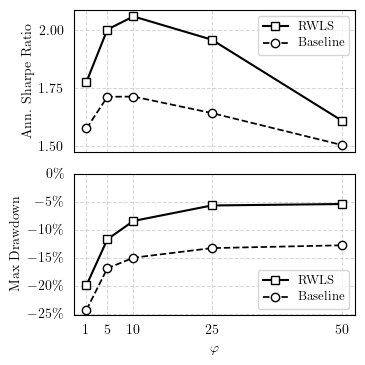

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(3.75, 3.75), sharex=True)

# Top plot
sr_mdl = rt_mdl.mean(axis=1) / rt_mdl.std(axis=1) * (12 ** 0.5)
sr_bsl = rt_bsl.mean(axis=1) / rt_bsl.std(axis=1) * (12 ** 0.5)

axs[0].plot(sr_mdl.groupby('phi').mean(), c='k', label='RWLS', marker='s', markerfacecolor='white', markeredgewidth=1)
axs[0].plot(sr_bsl.groupby('phi').mean(), c='k', label='Baseline', marker='o', markerfacecolor='white', markeredgewidth=1, lw=1.25, ls='--')
axs[0].set_ylabel('Ann. Sharpe Ratio')
axs[0].set_yticks([1.5, 1.75 , 2.0])
axs[0].legend(fontsize=9)

# Bottom plot
dd_mdl = rt_mdl.T.add(1).cumprod().div(rt_mdl.T.add(1).cumprod().cummax()).sub(1).min()
dd_bsl = rt_bsl.T.add(1).cumprod().div(rt_bsl.T.add(1).cumprod().cummax()).sub(1).min()

axs[1].plot(dd_mdl.groupby('phi').mean(), c='k', label='RWLS', marker='s', markerfacecolor='white', markeredgewidth=1)
axs[1].plot(dd_bsl.groupby('phi').mean(), c='k', label='Baseline', marker='o', markerfacecolor='white', markeredgewidth=1, lw=1.25, ls='--')
axs[1].set_ylabel('Max Drawdown')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[1].set_yticks([-0.25, -0.2, -0.15, -0.1, -0.05, 0.0])
axs[1].legend(fontsize=9)

axs[1].set_xlabel(r"$\varphi$")

for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.5, lw=0.75, zorder=-25)
    ax.set_xticks(list(sr_bsl.index.get_level_values('phi').unique()))
    ax.tick_params(bottom=False, left=False)

plt.tight_layout()
plt.savefig(f"{DataConstants.WDIR.value}/img/bt_panel_a.pdf", dpi=300, transparent=True)
plt.show()

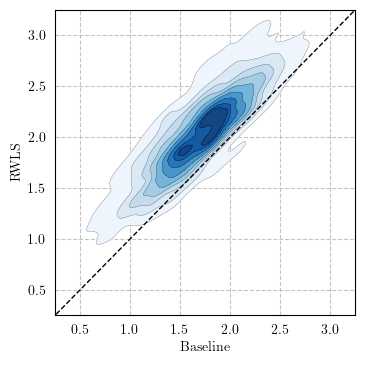

In [178]:
df = sr_mdl.to_frame(name='mdl').join(sr_bsl.to_frame(name='bsl'))

fig, ax = plt.subplots(figsize=(3.75, 3.75))
sns.kdeplot(x='bsl', y='mdl', bw_adjust=.75, ax=ax, data=df.xs(10, level='phi'), fill=True, zorder=25, cmap=sns.color_palette("Blues", as_cmap=True), alpha=.95)
sns.kdeplot(x='bsl', y='mdl', bw_adjust=.75, ax=ax, data=df.xs(10, level='phi'), fill=False, zorder=26, color='black', linewidths=.25, alpha=.5)
ax.tick_params(left=False, bottom=False)
ax.grid(ls='--', zorder=-25, alpha=.75, axis='both')
ax.set_xlim(0.25, 3.25)
ax.set_ylim(0.25, 3.25)
ax.plot([0, 3.5], [0, 3.5], color='black', lw=1, zorder=30, ls='--')
ax.set_xlabel('Baseline')
ax.set_ylabel('RWLS')

plt.tight_layout()
plt.savefig(f"{DataConstants.WDIR.value}/img/bt_panel_b.pdf", dpi=300, transparent=True)
plt.show()

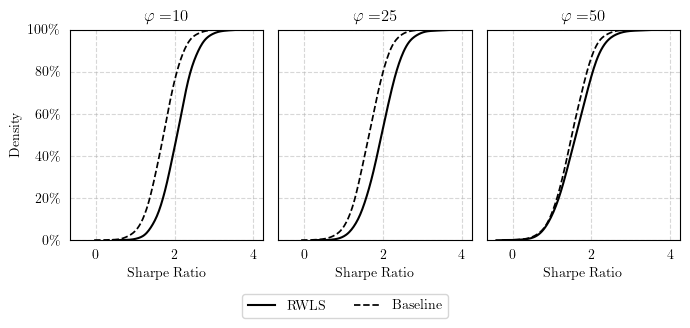

In [64]:
fig, axs = plt.subplots(ncols=3, figsize=(7, 3), sharex=True, sharey=True)

for i, phi in enumerate([10, 25, 50]):
    ax = axs[i]
    sns.kdeplot(data=sr_mdl.xs(phi, level='phi'), cumulative=True, ax=ax, zorder=25, lw=1.5, c='k', label='RWLS' if i == 0 else '')
    sns.kdeplot(data=sr_bsl.xs(phi, level='phi'), cumulative=True, ax=ax, ls='--', lw=1.25, zorder=25, c='k', label='Baseline' if i == 0 else '')
    ax.grid(ls='--', alpha=.5, zorder=-25)
    ax.set_title(fr"$\varphi=${phi}")
    ax.set_xlabel("Sharpe Ratio")
    ax.tick_params(bottom=False, left=False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    
    ax.set_ylim(0, 1)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=True)

plt.tight_layout()
plt.savefig(f"{DataConstants.WDIR.value}/img/bt_ecdf.pdf", dpi=300, transparent=True, bbox_inches='tight')
plt.show()